In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
daf_filename = '../daf_metric_results_folder_0817/{}DAF_TPCC_08172020/{}daf_count_agg_woLogging_{}thread.csv'
coor_filename = '../coor_metric_results_folder/coor_count_agg_woLogging_{}thread.csv'
total_num_threads = 20
daf_thread_count = [4, 8]
output_format = 'pdf'
xmin = 20
xmax = 135

In [3]:
df_coor = pd.read_csv (coor_filename.format(total_num_threads), header=0, skipinitialspace=True)

df0 = pd.read_csv (daf_filename.format(daf_thread_count[0], daf_thread_count[0], total_num_threads - daf_thread_count[0]), header=0, skipinitialspace=True)
df1 = pd.read_csv (daf_filename.format(daf_thread_count[1], daf_thread_count[1], total_num_threads - daf_thread_count[1]), header=0, skipinitialspace=True)

df_dafs = [df0, df1]

In [4]:
def clean_data(df):
    df = df.drop(columns=['start_time.1', 'cpu_id',
           'cpu_cycles', 'instructions', 'cache_ref', 'cache_miss',
           'ref_cpu_cycles_', 'block_read', 'block_write', 'memory_b',
           'elapsed_us'])
    # clear useless zeros at the end
    for index, row in df[::-1].iterrows():
        if row['total_num_actions'] == 0 and row['total_num_txns'] == 0:
            df = df.drop(df.index[[index]])
        else:
            break     
    # match up the time
    df = df.astype({'start_time': float})

    start_time = df.iloc[ 0 , : ]['start_time']
    for index, row in df.iterrows():
        df.at[index, 'start_time']  = (row['start_time'] - start_time) / 1000000.0
        
    # convert each count to equivalent num/second
    modify_columns = ['MEMORY_DEALLOCATION', 'CATALOG_TEARDOWN', 'INDEX_REMOVE_KEY', 'COMPACTION', 'LOG_RECORD_REMOVAL', 'TXN_REMOVAL', 'UNLINK', 'total_num_actions', 'total_num_txns']
    prev_time = df.iloc[ 0 , : ]['start_time']
    for index, row in df.iterrows():
        interval = row['start_time'] - prev_time
        for col_name in modify_columns:
            if interval == 0:
                df.at[index, col_name]  = 0
            else:  
                df.at[index, col_name] = row[col_name] / interval 
        prev_time = row['start_time']  
        
    # use only stable
    drop_idxs = []
    for index, row in df.iterrows():
        if row['start_time'] < xmin or row['start_time'] > xmax:
            drop_idxs.append(index)
    df = df.drop(df.index[drop_idxs])        
    return df    

In [5]:
def match_length(max_time_included, match_length_df):
    for index, row in match_length_df[::-1].iterrows():
        if row['start_time'] > max_time_included:
            match_length_df = match_length_df.drop(match_length_df.index[[index]])
        else:
            break
    return match_length_df       

In [6]:
df_coor = clean_data(df_coor)
for i in range(len(df_dafs)):
    df_dafs[i] = clean_data(df_dafs[i])

In [7]:
# match up to shortest

tails = []
tails.append(df_coor['start_time'].iloc[-1])
for df in df_dafs:
    tails.append(df['start_time'].iloc[-1])

min_tail = tails[0]
for tail in tails:
    if tail < min_tail:
        min_tail = tail

In [8]:
# df_coor = match_length(min_tail, df_coor)
# for i in range(len(df_dafs)):
#     df_dafs[i] = match_length(min_tail, df_dafs[i])

In [9]:
def change_font_sizes():
#     plt.rc('font', size=6)          # controls default text sizes
#     plt.rc('axes', titlesize=6)     # fontsize of the axes title
#     plt.rc('axes', labelsize=6)    # fontsize of the x and y labels
#     plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
#     plt.rc('ytick', labelsize=6)    # fontsize of the tick labels
    plt.rc('legend', fontsize=6)    # legend fontsize
#     plt.rc('figure', titlesize=6)  # fontsize of the figure title

[6.0, 4.0]


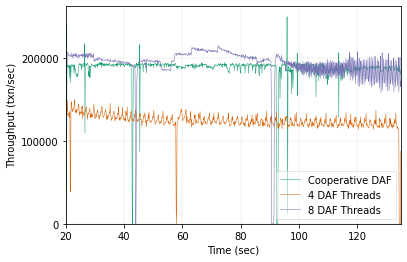

In [10]:
# draw only num_txns
# change_font_sizes()
plt.locator_params(axis='x', nbins=10)
plt.locator_params(axis='y', nbins=5)
plt.xlabel('Time (sec)')
plt.ylabel('Throughput (txn/sec)')
plt.grid(linestyle='-', linewidth='0.3', color='lightgrey')

colors = ['#1b9e77', '#d95f02', '#7570b3']

plt.plot( 'start_time', 'total_num_txns', data=df_coor, marker='', color=colors[0], linewidth=0.5, label='Cooperative DAF')
for i in range(len(df_dafs)):
    plt.plot( 'start_time', 'total_num_txns', data=df_dafs[i], marker='', color=colors[i + 1], linewidth=0.5, label='{} DAF Threads'.format(daf_thread_count[i]))
    
plt.legend(loc='best', ncol=1, framealpha=0.5)

plt.xlim([xmin, min_tail])
plt.ylim(ymin=0.0)

# plt.legend(loc='lower left', bbox_to_anchor=(0., 1.02, 1., .102), fancybox=True, shadow=True, ncol=2, mode='expand', borderaxespad=0.)
# use below if y axis labels in scientific notations
# plt.legend(loc='lower left', bbox_to_anchor=(0.08, 1.02, 0.92, .102), fancybox=True, shadow=True, ncol=2, mode='expand', borderaxespad=0.)

plt.savefig('../metric_figures/coor_vs_multi_txn_by_time.' + output_format, format=output_format,  bbox_inches='tight', dpi=600)
print(plt.rcParams["figure.figsize"])